In [5]:
!nvidia-smi

Wed Jan 12 13:39:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   39C    P0    56W / 300W |  15650MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:1C:00.0 Off |                    0 |
| N/A   

In [6]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import EfficientNetB3

In [9]:
# create a data generator
#datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=90, brightness_range=[1.0, 1.75], zoom_range=[0.5, 1.0], horizontal_flip = True, validation_split=0.1)

datagen = ImageDataGenerator(validation_split=0.1)

# Image size determined by EfficientNetB0
IMG_SIZE = 320

# load and iterate training dataset
train_it = datagen.flow_from_directory(
    '../master-data/train_small/rgb', 
    target_size=(IMG_SIZE, IMG_SIZE),
    subset="training", 
    class_mode="sparse",
    batch_size=32)

val_it = datagen.flow_from_directory(
    '../master-data/train_small/rgb', 
    target_size=(IMG_SIZE, IMG_SIZE), 
    subset="validation", 
    class_mode="sparse",
    batch_size=32)

Found 27011 images belonging to 11 classes.
Found 3000 images belonging to 11 classes.


In [10]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

optimizer = Adam(learning_rate=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor= 0.5, min_lr= 1e-6, verbose=1)

# Open a strategy scope.
with strategy.scope():
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    n_classes = 11
    efinet = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)

    model = Sequential()
    model.add(efinet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on all available devices.
history = model.fit(train_it, epochs=100, verbose=1, validation_data=val_it, callbacks=[early_stop, rlrop], workers=10)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

2022-01-12 13:43:52.952125: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_92653"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
. Consider eit

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
845/845 [==============================] - ETA: 0s - loss: 1.3900 - accuracy: 0.5551

2022-01-12 14:04:11.703635: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_170126"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
. Consider ei

845/845 [==============================] - 1418s 1s/step - loss: 1.3894 - accuracy: 0.5553 - val_loss: 0.6417 - val_accuracy: 0.8030
Epoch 2/100
845/845 [==============================] - 300s 353ms/step - loss: 0.3290 - accuracy: 0.8879 - val_loss: 0.3809 - val_accuracy: 0.8833
Epoch 3/100
845/845 [==============================] - 301s 354ms/step - loss: 0.1983 - accuracy: 0.9350 - val_loss: 0.4741 - val_accuracy: 0.8760
Epoch 4/100
845/845 [==============================] - 304s 358ms/step - loss: 0.1377 - accuracy: 0.9523 - val_loss: 0.6773 - val_accuracy: 0.7957
Epoch 5/100
845/845 [==============================] - 299s 352ms/step - loss: 0.0972 - accuracy: 0.9665 - val_loss: 0.5513 - val_accuracy: 0.8483
Epoch 6/100
845/845 [==============================] - 298s 351ms/step - loss: 0.0818 - accuracy: 0.9712 - val_loss: 0.4816 - val_accuracy: 0.8803
Epoch 7/100
845/845 [==============================] - 299s 352ms/step - loss: 0.0700 - accuracy: 0.9766 - val_loss: 0.3675 - val_ac

In [11]:
model.save_weights("efficientnetb3_weights.h5")
model.save('./efficientnetb3', save_format='tf')

2022-01-12 16:42:40.642090: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./efficientnetb3/assets


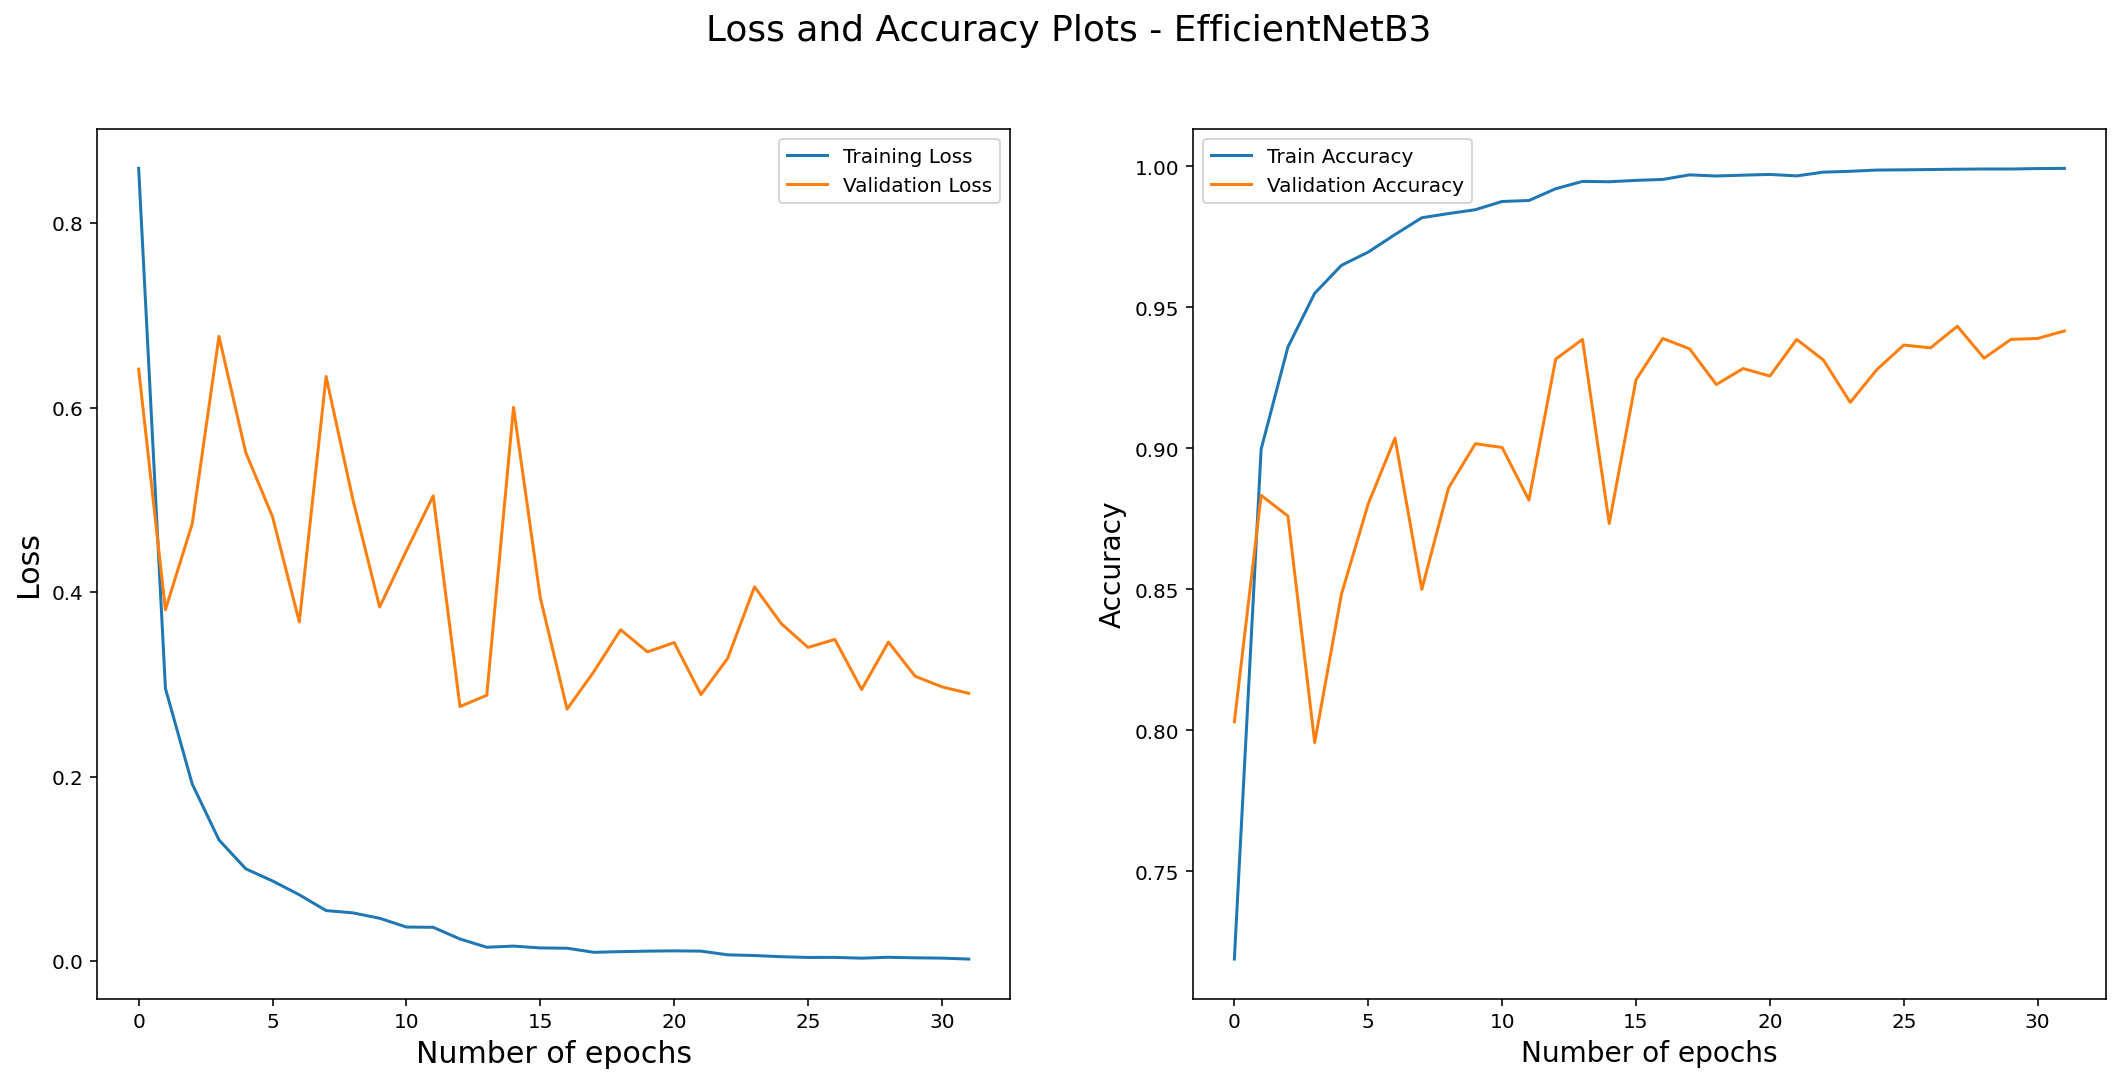

In [12]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots - EfficientNetB3', fontsize=18)

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.savefig('efficientnetb5.pdf')
plt.show()

In [13]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history-efficientnetb3.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)